In [56]:
dev = torch.device('cpu')
if torch.cuda.is_available():
    print("CUDA is available, running on GPU")
    dev = torch.device('cuda')
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    print("CUDA not available, running on CPU")
mpl.rcParams['figure.dpi'] = 100
# fix random seeds
axes = {'labelsize' : 'large'}2
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 17}
legend = {'fontsize': 'medium'}
lines = {'linewidth': 3,
         'markersize' : 7}
mpl.rc('font', **font)
mpl.rc('axes', **axes)
mpl.rc('legend', **legend)
mpl.rc('lines', **lines)
npr.seed(2023)
torch.manual_seed(2023)


# ------------------------------ network settings ---------------------------------------------------
# torch.set_default_dtype(torch.float64)
iteration = 200
D_in = 1
H = 64
D_out = 1
learning_rate = 0.0001
# ------------------------------ material parameter -------------------------------------------------
model_energy = 'EulerBeam'
# ----------------------------- define structural parameters ---------------------------------------
L = 4
L1 = 1.2
L2 = 2.2
L3 = 3.8
dense_width = 0.2
Length = 4
H_0 = 0.6
H_1 = 0.2
b = 0.1
Depth = 1
A = b*Depth
nu = 0.3
k=10*(1+nu)/(12+11*nu)
a=3
kr=1000
kl=100

#II = Depth*Height**3/12
II = b*Depth**3/12
EE = 2.10*10**6
G = EE/2/(1+nu)
p = 100
# ------------------------------ define domain and collocation points -------------------------------
Nx1 = 6000  # 120  # 120
Nx2 = 2000
Nx3 = 6000
Nx4 = 6000

x_min = 0
# ------------------------------ data testing -------------------------------------------------------
num_test_x1 = 2*Nx1
num_test_x2 = 2*Nx2
num_test_x3 = 2*Nx3
num_test_x4 = 2*Nx4

# Purpose: setting domain and collect database
# -------------------------------------------------------------------------------
def setup_domain():
    # create points
    dom1 = np.array([np.linspace(0, L1-dense_width, Nx1)]).T
    dom2 = np.array([np.linspace(L1-dense_width,L1+dense_width, Nx2)]).T
    dom3 = np.array([np.linspace(L1+dense_width, L2-dense_width, Nx3)]).T
    dom4 = np.array([np.linspace(L2-dense_width, L2+dense_width, Nx2)]).T
    dom5 = np.array([np.linspace(L2+dense_width, L3-dense_width, Nx4)]).T
    dom6 = np.array([np.linspace(L3-dense_width, L3+dense_width, Nx2)]).T
    dom7 = np.array([np.linspace(L3+dense_width, L, Nx3)]).T
    dom = np.concatenate((dom1,dom2,dom3,dom4,dom5,dom6,dom7),axis=0)
    #dom = dom.shuffe
    #dom = np.array([np.linspace(0, L, Nx)]).T
    
    return dom
#create points that have equal distance

# -----------------------------------------------------------------------------------------------------
# prepare inputs for testing the model
# -----------------------------------------------------------------------------------------------------
def get_datatest():
    # create points
    x_space1 = np.sort(np.random.uniform(0, L1-dense_width, size=(num_test_x1, 1)), axis=0)
    x_space2 = np.sort(np.random.uniform(L1-dense_width,L1+dense_width, size=(num_test_x2, 1)), axis=0)
    x_space3 = np.sort(np.random.uniform(L1+dense_width, L2-dense_width, size=(num_test_x3, 1)), axis=0)
    x_space4 = np.sort(np.random.uniform(L2-dense_width, L2+dense_width, size=(num_test_x2, 1)), axis=0)
    x_space5 = np.sort(np.random.uniform(L2+dense_width, L3-dense_width, size=(num_test_x4, 1)), axis=0)
    x_space6 = np.sort(np.random.uniform(L3-dense_width, L3+dense_width, size=(num_test_x2, 1)), axis=0)
    x_space7 = np.sort(np.random.uniform(L3+dense_width, L, size=(num_test_x3, 1)), axis=0)
    x_space = np.concatenate((x_space1,x_space2, x_space3, x_space4,x_space5, x_space6, x_space7),axis=0)
#     x_space = np.sort(np.random.uniform(x_min, L, size=(num_test_x, 1)), axis=0)
    return x_space
    
# --------------------------------------------------------------------------
#           NEURAL NETWORK CLASS
# --------------------------------------------------------------------------
class MultiLayerNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(MultiLayerNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, H)
        self.linear3 = torch.nn.Linear(H, H)
        self.linear4 = torch.nn.Linear(H, H)
        self.linear5 = torch.nn.Linear(H, D_out)
        torch.nn.init.constant_(self.linear1.bias, 0.)
        torch.nn.init.constant_(self.linear2.bias, 0.)
        torch.nn.init.constant_(self.linear3.bias, 0.)
        torch.nn.init.constant_(self.linear4.bias, 0.)
        torch.nn.init.constant_(self.linear5.bias, 0.)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        y1 = torch.tanh(self.linear1(x))
        y2 = torch.tanh(self.linear2(y1))
        y3 = torch.tanh(self.linear3(y2))
        y4 = torch.tanh(self.linear4(y3))
        y = self.linear5(y4)
        return y
    
# --------------------------------------------------------------------------------
#       MAIN CLASS: Deep Energy Method
# --------------------------------------------------------------------------------
class PhysicalInformedNN:
    # Instance attributes
    def __init__(self, model):
        self.model = MultiLayerNet(model[0], model[1], model[2])
        self.model = self.model.to(dev)

    # ------------------------------------------------------------------
    # Purpose: training model
    # ------------------------------------------------------------------
    def train_model(self, data, iteration):
        x = torch.from_numpy(data).float()
        x = x.to(dev)
        x.requires_grad_(True) #启用对张量x的梯度计算
        
        nearest_index = np.argmin(np.abs(dom - L1))
        
        L1_left = (L1-0.0001)*np.ones((1,1))
        L1_left = torch.Tensor(L1_left).float()
        L1_left.requires_grad_(True)
        L1_right = (L1+0.0001)*np.ones((1,1))
        L1_right = torch.Tensor(L1_right).float()
        L1_right.requires_grad_(True)
        nearest_index_L1 = np.argmin(np.abs(dom - L1))
        
        L2_left = (L2-0.0001)*np.ones((1,1))
        L2_left = torch.Tensor(L2_left).float()
        L2_left.requires_grad_(True)
        L2_right = (L2+0.0001)*np.ones((1,1))
        L2_right = torch.Tensor(L2_right).float()
        L2_right.requires_grad_(True)
        nearest_index_L2 = np.argmin(np.abs(dom - L2))

        xbnd1 = L*np.ones((1,1))
        xbnd1 = torch.Tensor(xbnd1).float()
        xbnd1.requires_grad_(True)
        
        xbnd2 = L2*np.ones((1,1))
        xbnd2 = torch.Tensor(xbnd2).float()
        xbnd2.requires_grad_(True)
        
        xbnd3 = L3*np.ones((1,1))
        xbnd3 = torch.Tensor(xbnd3).float()
        xbnd3.requires_grad_(True)
        
        optimizer = torch.optim.LBFGS(self.model.parameters(), lr=learning_rate, max_iter=50)
        start_time = time.time()
        loss_array = []
#         criterion = torch.nn.MSELoss()
        it_time = time.time()  #迭代开始时间
        for t in range(iteration):
            # Zero gradients, perform a backward pass, and update the weights.
            def closure():
                u_pred, dudx_pred, dudx2_pred, dudx3_pred, dudx4_pred= self.getU(x)
                u_pred.double()
#                 print(u_pred[-1])
                dudx_pred.double()
                dudx2_pred.double()
                dudx3_pred.double()
                dudx4_pred.double()
                u_f_pred = u_pred[nearest_index]
                loss1 = torch.mean((dudx4_pred -p*u_f_pred/EE/II)**2)  #Residual error
                
                
                dudx2_bnd1,dudx3_bnd1 = self.getUbnd1(xbnd1)   #free boundary
                dudx2_bnd1.double()
                dudx3_bnd1.double()
                loss2 = torch.mean(dudx2_bnd1**2)
                loss3 = torch.mean(dudx3_bnd1**2)
                
                dudx_bnd2,dudx2_bnd2 = self.getUbnd2(xbnd2)  #Rotation spring support
                dudx_bnd2.double()
                dudx2_bnd2.double()
                loss4 = torch.mean((kr*dudx_bnd2/EE/II+dudx2_bnd2)**2)
                
                u_bnd3,dudx3_bnd2 = self.getUbnd3(xbnd3)
                u_bnd3.double()
                dudx3_bnd2.double()
                loss5 = torch.mean((kl*u_bnd3/EE/II+dudx3_bnd2)**2)
                
                
                dudx3_left= self.getU_L1(L1_left)   #concentrate force
                dudx3_left.double()
                dudx3_right= self.getU_L1(L1_right)
                dudx3_right.double()
                loss6 = torch.mean((dudx3_left-dudx3_right-p/EE/II)**2)
                
                dudx2_left= self.getU_L2(L2_left)
                dudx2_left.double()
                dudx2_right= self.getU_L2(L2_right)
                dudx2_right.double()
                
                dudx_L2= self.getU_L2_2(xbnd2)
                dudx_L2.double()
                loss7 = torch.mean((dudx2_left-dudx2_right-kr*dudx_L2/EE/II)**2)
                
                
                #loss = torch.sum(potential_energy*h) - torch.sum(f1*h)
                loss = loss1 + loss2 + loss3 + loss4 + loss5 + loss6 + loss7
                optimizer.zero_grad()
                loss.backward()
                print('Iter: %d Loss: %.9e Time: %.3e'
                      % (t + 1, loss.item(), time.time() - it_time))
                loss_array.append(loss.data)
                return loss
            optimizer.step(closure)
            loss_history = np.array([item.cpu() for item in loss_array])
            file_path = 'C:/jiamin/dem-stastic-paper1/EulerBeam/losshistory_EulerBeam_case5_pinn.npy'
            np.save(file_path,loss_history)
        elapsedDEM = time.time() - start_time
        print('Training time: %.4f' % elapsedDEM)

    def getU(self, x):
        u = self.model(x)
        w = x**2*u
        dudx_torch = grad(w, x, torch.ones(x.shape[0], 1, device=dev), create_graph=True)[0]
        dudx2_torch = grad(dudx_torch, x, torch.ones(x.shape[0], 1, device=dev), create_graph=True)[0]
        dudx3_torch = grad(dudx2_torch, x, torch.ones(x.shape[0], 1, device=dev), create_graph=True)[0]
        dudx4_torch = grad(dudx3_torch, x, torch.ones(x.shape[0], 1, device=dev), create_graph=True)[0]
        return w,dudx_torch,dudx2_torch,dudx3_torch,dudx4_torch
    
    def getUbnd1(self, xbnd):
        u = self.model(xbnd)
        w = xbnd**2*u
        dudx_torch = grad(w, xbnd, torch.ones(xbnd.shape[0], 1, device=dev), create_graph=True)[0]
        dudx2_torch = grad(dudx_torch, xbnd, torch.ones(xbnd.shape[0], 1, device=dev), create_graph=True)[0]
        dudx3_torch = grad(dudx2_torch, xbnd, torch.ones(xbnd.shape[0], 1, device=dev), create_graph=True)[0]
        return dudx2_torch,dudx3_torch
    
    def getUbnd2(self, xbnd):
        u = self.model(xbnd)
        w = xbnd**2*u
        dudx_torch = grad(w, xbnd, torch.ones(xbnd.shape[0], 1, device=dev), create_graph=True)[0]
        dudx2_torch = grad(dudx_torch, xbnd, torch.ones(xbnd.shape[0], 1, device=dev), create_graph=True)[0]
        return dudx_torch,dudx2_torch
    
    def getUbnd3(self, xbnd):
        u = self.model(xbnd)
        w = xbnd**2*u
        dudx_torch = grad(w, xbnd, torch.ones(xbnd.shape[0], 1, device=dev), create_graph=True)[0]
        dudx2_torch = grad(dudx_torch, xbnd, torch.ones(xbnd.shape[0], 1, device=dev), create_graph=True)[0]
        dudx3_torch = grad(dudx2_torch, xbnd, torch.ones(xbnd.shape[0], 1, device=dev), create_graph=True)[0]
        return w,dudx3_torch

    def getU_L1(self, xa):
        u = self.model(xa)
        w = xa**2*u
        dudx_torch = grad(w, xa, torch.ones(xa.shape[0], 1, device=dev), create_graph=True)[0]
        dudx2_torch = grad(dudx_torch, xa, torch.ones(xa.shape[0], 1, device=dev), create_graph=True)[0]
        dudx3_torch = grad(dudx2_torch, xa, torch.ones(xa.shape[0], 1, device=dev), create_graph=True)[0]
        return dudx3_torch
    
    def getU_L2(self, xa):
        u = self.model(xa)
        w = xa**2*u
        dudx_torch = grad(w, xa, torch.ones(xa.shape[0], 1, device=dev), create_graph=True)[0]
        dudx2_torch = grad(dudx_torch, xa, torch.ones(xa.shape[0], 1, device=dev), create_graph=True)[0]
        return dudx2_torch
    
    def getU_L2_2(self, xa):
        u = self.model(xa)
        w = xa**2*u
        dudx_torch = grad(w, xa, torch.ones(xa.shape[0], 1, device=dev), create_graph=True)[0]
        return dudx_torch
    

    def evaluate_model(self, x_space):
        t_tensor = torch.from_numpy(x_space).float()
        t_tensor = t_tensor.to(dev)
        t_tensor.requires_grad_(True)
        w, dudx_torch, dudx2_torch, dudx3_torch, dudx4_torch = self.getU(t_tensor)
        
        u_pred = w.detach().cpu().numpy()
        dudx_pred = dudx_torch.detach().cpu().numpy()
        dudx2_pred = dudx2_torch.detach().cpu().numpy()
        dudx3_pred = dudx3_torch.detach().cpu().numpy()
        
        return u_pred, dudx_pred, dudx2_pred, dudx3_pred

CUDA is available, running on GPU


In [57]:
dom = setup_domain()  #[1000,1]
x_predict = get_datatest() #[num_test_x, 1]
dems = PhysicalInformedNN([D_in, H, D_out])
time_dems = time.time()
dems.train_model(dom, iteration)
time_dems = time.time() - time_dems
u_pred, dudx_pred, dudx2_pred, dudx3_pred = dems.evaluate_model(x_predict)
M_pinn = EE*II*dudx2_pred
V_pinn =  EE*II*dudx3_pred
#error_L2_DEMS = np.linalg.norm(exact_solution - u_pred, 2) / np.linalg.norm(exact_solution, 2)

Iter: 1 Loss: 2.931078337e-02 Time: 3.271e-01
Iter: 1 Loss: 2.930708975e-02 Time: 5.027e-01
Iter: 1 Loss: 2.930265851e-02 Time: 6.652e-01
Iter: 1 Loss: 2.929788642e-02 Time: 8.617e-01
Iter: 1 Loss: 2.929287776e-02 Time: 1.075e+00
Iter: 1 Loss: 2.928769216e-02 Time: 1.241e+00
Iter: 1 Loss: 2.928238176e-02 Time: 1.430e+00
Iter: 1 Loss: 2.927697077e-02 Time: 1.622e+00
Iter: 1 Loss: 2.927148715e-02 Time: 1.798e+00
Iter: 1 Loss: 2.926592529e-02 Time: 1.986e+00
Iter: 1 Loss: 2.926030941e-02 Time: 2.236e+00
Iter: 1 Loss: 2.925462276e-02 Time: 2.448e+00
Iter: 1 Loss: 2.924888767e-02 Time: 2.683e+00
Iter: 1 Loss: 2.924307249e-02 Time: 2.860e+00
Iter: 1 Loss: 2.923721820e-02 Time: 3.102e+00
Iter: 1 Loss: 2.923129499e-02 Time: 3.330e+00
Iter: 1 Loss: 2.922527492e-02 Time: 3.546e+00
Iter: 1 Loss: 2.921921946e-02 Time: 3.741e+00
Iter: 1 Loss: 2.921305224e-02 Time: 3.923e+00
Iter: 1 Loss: 2.920682542e-02 Time: 4.108e+00
Iter: 1 Loss: 2.920051478e-02 Time: 4.323e+00
Iter: 1 Loss: 2.919411659e-02 Time

Iter: 4 Loss: 2.194366232e-02 Time: 4.031e+01
Iter: 4 Loss: 2.189626172e-02 Time: 4.049e+01
Iter: 4 Loss: 2.184775099e-02 Time: 4.070e+01
Iter: 4 Loss: 2.179779485e-02 Time: 4.091e+01
Iter: 4 Loss: 2.174659632e-02 Time: 4.113e+01
Iter: 4 Loss: 2.169390582e-02 Time: 4.132e+01
Iter: 4 Loss: 2.163961716e-02 Time: 4.153e+01
Iter: 4 Loss: 2.158370987e-02 Time: 4.173e+01
Iter: 4 Loss: 2.152623795e-02 Time: 4.195e+01
Iter: 4 Loss: 2.146710269e-02 Time: 4.213e+01
Iter: 4 Loss: 2.140619792e-02 Time: 4.233e+01
Iter: 4 Loss: 2.134366706e-02 Time: 4.258e+01
Iter: 4 Loss: 2.127986588e-02 Time: 4.280e+01
Iter: 4 Loss: 2.121453732e-02 Time: 4.301e+01
Iter: 4 Loss: 2.114819549e-02 Time: 4.324e+01
Iter: 4 Loss: 2.108045481e-02 Time: 4.343e+01
Iter: 4 Loss: 2.101172693e-02 Time: 4.362e+01
Iter: 4 Loss: 2.094237693e-02 Time: 4.383e+01
Iter: 4 Loss: 2.087234333e-02 Time: 4.403e+01
Iter: 4 Loss: 2.080209740e-02 Time: 4.429e+01
Iter: 4 Loss: 2.073155716e-02 Time: 4.457e+01
Iter: 5 Loss: 2.066089213e-02 Time

Iter: 8 Loss: 1.373730879e-02 Time: 7.977e+01
Iter: 8 Loss: 1.369963214e-02 Time: 7.998e+01
Iter: 8 Loss: 1.366204955e-02 Time: 8.017e+01
Iter: 8 Loss: 1.362488978e-02 Time: 8.037e+01
Iter: 8 Loss: 1.358795445e-02 Time: 8.059e+01
Iter: 8 Loss: 1.355126873e-02 Time: 8.084e+01
Iter: 8 Loss: 1.351475623e-02 Time: 8.106e+01
Iter: 8 Loss: 1.347866282e-02 Time: 8.129e+01
Iter: 8 Loss: 1.344270539e-02 Time: 8.158e+01
Iter: 8 Loss: 1.340693608e-02 Time: 8.183e+01
Iter: 8 Loss: 1.337145735e-02 Time: 8.204e+01
Iter: 8 Loss: 1.333629899e-02 Time: 8.227e+01
Iter: 8 Loss: 1.330118440e-02 Time: 8.247e+01
Iter: 8 Loss: 1.326634549e-02 Time: 8.270e+01
Iter: 8 Loss: 1.323182788e-02 Time: 8.290e+01
Iter: 8 Loss: 1.319743786e-02 Time: 8.310e+01
Iter: 8 Loss: 1.316326484e-02 Time: 8.331e+01
Iter: 8 Loss: 1.312920917e-02 Time: 8.351e+01
Iter: 8 Loss: 1.309541054e-02 Time: 8.375e+01
Iter: 8 Loss: 1.306176744e-02 Time: 8.400e+01
Iter: 8 Loss: 1.302839629e-02 Time: 8.426e+01
Iter: 8 Loss: 1.299506798e-02 Time

Iter: 11 Loss: 8.474258706e-03 Time: 1.200e+02
Iter: 11 Loss: 8.445561863e-03 Time: 1.202e+02
Iter: 11 Loss: 8.417441510e-03 Time: 1.204e+02
Iter: 11 Loss: 8.389861323e-03 Time: 1.206e+02
Iter: 11 Loss: 8.362839930e-03 Time: 1.209e+02
Iter: 11 Loss: 8.336408995e-03 Time: 1.211e+02
Iter: 11 Loss: 8.310439065e-03 Time: 1.213e+02
Iter: 11 Loss: 8.284986950e-03 Time: 1.215e+02
Iter: 11 Loss: 8.260037750e-03 Time: 1.217e+02
Iter: 11 Loss: 8.235558867e-03 Time: 1.219e+02
Iter: 11 Loss: 8.211410604e-03 Time: 1.221e+02
Iter: 11 Loss: 8.187951520e-03 Time: 1.224e+02
Iter: 11 Loss: 8.164681494e-03 Time: 1.227e+02
Iter: 11 Loss: 8.142019622e-03 Time: 1.229e+02
Iter: 12 Loss: 8.119774982e-03 Time: 1.232e+02
Iter: 12 Loss: 8.097841404e-03 Time: 1.234e+02
Iter: 12 Loss: 8.076299913e-03 Time: 1.236e+02
Iter: 12 Loss: 8.055119775e-03 Time: 1.239e+02
Iter: 12 Loss: 8.034321479e-03 Time: 1.241e+02
Iter: 12 Loss: 8.013878018e-03 Time: 1.243e+02
Iter: 12 Loss: 7.993849926e-03 Time: 1.246e+02
Iter: 12 Loss

Iter: 15 Loss: 5.659402348e-03 Time: 1.595e+02
Iter: 15 Loss: 5.649392959e-03 Time: 1.596e+02
Iter: 15 Loss: 5.639383569e-03 Time: 1.599e+02
Iter: 15 Loss: 5.629466381e-03 Time: 1.601e+02
Iter: 15 Loss: 5.619554315e-03 Time: 1.603e+02
Iter: 15 Loss: 5.609926302e-03 Time: 1.605e+02
Iter: 15 Loss: 5.600133911e-03 Time: 1.607e+02
Iter: 15 Loss: 5.590745248e-03 Time: 1.609e+02
Iter: 15 Loss: 5.581106059e-03 Time: 1.611e+02
Iter: 15 Loss: 5.571709480e-03 Time: 1.614e+02
Iter: 15 Loss: 5.562290084e-03 Time: 1.616e+02
Iter: 15 Loss: 5.552957766e-03 Time: 1.618e+02
Iter: 15 Loss: 5.543895531e-03 Time: 1.620e+02
Iter: 15 Loss: 5.534775555e-03 Time: 1.622e+02
Iter: 15 Loss: 5.525771994e-03 Time: 1.624e+02
Iter: 15 Loss: 5.516656209e-03 Time: 1.626e+02
Iter: 15 Loss: 5.507960916e-03 Time: 1.628e+02
Iter: 15 Loss: 5.499112885e-03 Time: 1.631e+02
Iter: 15 Loss: 5.490376148e-03 Time: 1.633e+02
Iter: 15 Loss: 5.481889006e-03 Time: 1.635e+02
Iter: 15 Loss: 5.473382771e-03 Time: 1.637e+02
Iter: 15 Loss

Iter: 18 Loss: 4.588496871e-03 Time: 1.965e+02
Iter: 18 Loss: 4.580033012e-03 Time: 1.967e+02
Iter: 18 Loss: 4.571830388e-03 Time: 1.969e+02
Iter: 18 Loss: 4.563751630e-03 Time: 1.971e+02
Iter: 18 Loss: 4.555738997e-03 Time: 1.973e+02
Iter: 18 Loss: 4.547748715e-03 Time: 1.975e+02
Iter: 18 Loss: 4.539779853e-03 Time: 1.977e+02
Iter: 18 Loss: 4.531950224e-03 Time: 1.979e+02
Iter: 18 Loss: 4.523957148e-03 Time: 1.981e+02
Iter: 18 Loss: 4.515986424e-03 Time: 1.983e+02
Iter: 18 Loss: 4.507916514e-03 Time: 1.985e+02
Iter: 18 Loss: 4.499759991e-03 Time: 1.987e+02
Iter: 18 Loss: 4.491425585e-03 Time: 1.989e+02
Iter: 18 Loss: 4.482883494e-03 Time: 1.991e+02
Iter: 19 Loss: 4.474144429e-03 Time: 1.994e+02
Iter: 19 Loss: 4.464886617e-03 Time: 1.996e+02
Iter: 19 Loss: 4.455197137e-03 Time: 1.998e+02
Iter: 19 Loss: 4.445069935e-03 Time: 2.000e+02
Iter: 19 Loss: 4.434244242e-03 Time: 2.002e+02
Iter: 19 Loss: 4.422648344e-03 Time: 2.004e+02
Iter: 19 Loss: 4.410247784e-03 Time: 2.006e+02
Iter: 19 Loss

Iter: 22 Loss: 2.754975343e-03 Time: 2.331e+02
Iter: 22 Loss: 2.747468650e-03 Time: 2.333e+02
Iter: 22 Loss: 2.740149153e-03 Time: 2.335e+02
Iter: 22 Loss: 2.732969122e-03 Time: 2.337e+02
Iter: 22 Loss: 2.725858241e-03 Time: 2.339e+02
Iter: 22 Loss: 2.718978329e-03 Time: 2.341e+02
Iter: 22 Loss: 2.712183399e-03 Time: 2.343e+02
Iter: 22 Loss: 2.705499064e-03 Time: 2.346e+02
Iter: 22 Loss: 2.698969329e-03 Time: 2.348e+02
Iter: 22 Loss: 2.692538314e-03 Time: 2.350e+02
Iter: 22 Loss: 2.686211374e-03 Time: 2.352e+02
Iter: 22 Loss: 2.680031816e-03 Time: 2.354e+02
Iter: 22 Loss: 2.673906740e-03 Time: 2.356e+02
Iter: 22 Loss: 2.667915542e-03 Time: 2.358e+02
Iter: 22 Loss: 2.662042156e-03 Time: 2.361e+02
Iter: 22 Loss: 2.656219760e-03 Time: 2.363e+02
Iter: 22 Loss: 2.650519134e-03 Time: 2.365e+02
Iter: 22 Loss: 2.644881606e-03 Time: 2.367e+02
Iter: 22 Loss: 2.639325801e-03 Time: 2.369e+02
Iter: 22 Loss: 2.633840544e-03 Time: 2.371e+02
Iter: 22 Loss: 2.628464717e-03 Time: 2.373e+02
Iter: 22 Loss

Iter: 25 Loss: 1.796892029e-03 Time: 2.698e+02
Iter: 25 Loss: 1.793211093e-03 Time: 2.700e+02
Iter: 25 Loss: 1.789571485e-03 Time: 2.702e+02
Iter: 25 Loss: 1.785958302e-03 Time: 2.705e+02
Iter: 25 Loss: 1.782403677e-03 Time: 2.707e+02
Iter: 25 Loss: 1.778889564e-03 Time: 2.709e+02
Iter: 25 Loss: 1.775428886e-03 Time: 2.711e+02
Iter: 25 Loss: 1.771992538e-03 Time: 2.713e+02
Iter: 25 Loss: 1.768555492e-03 Time: 2.715e+02
Iter: 25 Loss: 1.765192486e-03 Time: 2.717e+02
Iter: 25 Loss: 1.761834486e-03 Time: 2.719e+02
Iter: 25 Loss: 1.758505474e-03 Time: 2.721e+02
Iter: 25 Loss: 1.755203353e-03 Time: 2.723e+02
Iter: 25 Loss: 1.751946867e-03 Time: 2.725e+02
Iter: 26 Loss: 1.748692594e-03 Time: 2.729e+02
Iter: 26 Loss: 1.745473943e-03 Time: 2.731e+02
Iter: 26 Loss: 1.742288470e-03 Time: 2.733e+02
Iter: 26 Loss: 1.739117783e-03 Time: 2.735e+02
Iter: 26 Loss: 1.735956990e-03 Time: 2.737e+02
Iter: 26 Loss: 1.732801436e-03 Time: 2.739e+02
Iter: 26 Loss: 1.729667070e-03 Time: 2.741e+02
Iter: 26 Loss

Iter: 29 Loss: 1.275992021e-03 Time: 3.066e+02
Iter: 29 Loss: 1.272686175e-03 Time: 3.068e+02
Iter: 29 Loss: 1.269557979e-03 Time: 3.070e+02
Iter: 29 Loss: 1.266512088e-03 Time: 3.073e+02
Iter: 29 Loss: 1.263582264e-03 Time: 3.075e+02
Iter: 29 Loss: 1.260676421e-03 Time: 3.077e+02
Iter: 29 Loss: 1.257900964e-03 Time: 3.079e+02
Iter: 29 Loss: 1.255196985e-03 Time: 3.081e+02
Iter: 29 Loss: 1.252548653e-03 Time: 3.083e+02
Iter: 29 Loss: 1.249983790e-03 Time: 3.085e+02
Iter: 29 Loss: 1.247520209e-03 Time: 3.087e+02
Iter: 29 Loss: 1.245100284e-03 Time: 3.089e+02
Iter: 29 Loss: 1.242699567e-03 Time: 3.091e+02
Iter: 29 Loss: 1.240321668e-03 Time: 3.093e+02
Iter: 29 Loss: 1.238035155e-03 Time: 3.095e+02
Iter: 29 Loss: 1.235788222e-03 Time: 3.097e+02
Iter: 29 Loss: 1.233589370e-03 Time: 3.099e+02
Iter: 29 Loss: 1.231405418e-03 Time: 3.101e+02
Iter: 29 Loss: 1.229247660e-03 Time: 3.103e+02
Iter: 29 Loss: 1.227150788e-03 Time: 3.106e+02
Iter: 29 Loss: 1.225075335e-03 Time: 3.108e+02
Iter: 29 Loss

Iter: 32 Loss: 1.071148785e-03 Time: 3.434e+02
Iter: 32 Loss: 1.070508151e-03 Time: 3.436e+02
Iter: 32 Loss: 1.069869264e-03 Time: 3.438e+02
Iter: 32 Loss: 1.069229562e-03 Time: 3.441e+02
Iter: 32 Loss: 1.068589860e-03 Time: 3.443e+02
Iter: 32 Loss: 1.067949808e-03 Time: 3.444e+02
Iter: 32 Loss: 1.067311969e-03 Time: 3.446e+02
Iter: 32 Loss: 1.066670637e-03 Time: 3.449e+02
Iter: 32 Loss: 1.066031167e-03 Time: 3.451e+02
Iter: 32 Loss: 1.065391931e-03 Time: 3.453e+02
Iter: 32 Loss: 1.064752578e-03 Time: 3.455e+02
Iter: 32 Loss: 1.064112061e-03 Time: 3.457e+02
Iter: 32 Loss: 1.063477946e-03 Time: 3.459e+02
Iter: 33 Loss: 1.062839408e-03 Time: 3.462e+02
Iter: 33 Loss: 1.062201220e-03 Time: 3.465e+02
Iter: 33 Loss: 1.061563031e-03 Time: 3.467e+02
Iter: 33 Loss: 1.060926239e-03 Time: 3.469e+02
Iter: 33 Loss: 1.060288632e-03 Time: 3.471e+02
Iter: 33 Loss: 1.059653237e-03 Time: 3.473e+02
Iter: 33 Loss: 1.059015864e-03 Time: 3.475e+02
Iter: 33 Loss: 1.058379188e-03 Time: 3.477e+02
Iter: 33 Loss

Iter: 36 Loss: 9.845953900e-04 Time: 3.802e+02
Iter: 36 Loss: 9.842038853e-04 Time: 3.804e+02
Iter: 36 Loss: 9.838109836e-04 Time: 3.806e+02
Iter: 36 Loss: 9.834145894e-04 Time: 3.808e+02
Iter: 36 Loss: 9.830226190e-04 Time: 3.810e+02
Iter: 36 Loss: 9.826270398e-04 Time: 3.812e+02
Iter: 36 Loss: 9.822313441e-04 Time: 3.814e+02
Iter: 36 Loss: 9.818411199e-04 Time: 3.816e+02
Iter: 36 Loss: 9.814461228e-04 Time: 3.818e+02
Iter: 36 Loss: 9.810531046e-04 Time: 3.820e+02
Iter: 36 Loss: 9.806586895e-04 Time: 3.823e+02
Iter: 36 Loss: 9.802654386e-04 Time: 3.824e+02
Iter: 36 Loss: 9.798702085e-04 Time: 3.827e+02
Iter: 36 Loss: 9.794773068e-04 Time: 3.829e+02
Iter: 36 Loss: 9.790847544e-04 Time: 3.831e+02
Iter: 36 Loss: 9.786927840e-04 Time: 3.833e+02
Iter: 36 Loss: 9.782983689e-04 Time: 3.835e+02
Iter: 36 Loss: 9.779062821e-04 Time: 3.837e+02
Iter: 36 Loss: 9.775130311e-04 Time: 3.839e+02
Iter: 36 Loss: 9.771211771e-04 Time: 3.841e+02
Iter: 36 Loss: 9.767283918e-04 Time: 3.843e+02
Iter: 36 Loss

Iter: 39 Loss: 9.171965648e-04 Time: 4.167e+02
Iter: 39 Loss: 9.168219985e-04 Time: 4.169e+02
Iter: 39 Loss: 9.164479561e-04 Time: 4.171e+02
Iter: 39 Loss: 9.160732734e-04 Time: 4.173e+02
Iter: 39 Loss: 9.156986489e-04 Time: 4.176e+02
Iter: 39 Loss: 9.153248393e-04 Time: 4.178e+02
Iter: 39 Loss: 9.149512043e-04 Time: 4.179e+02
Iter: 39 Loss: 9.145779768e-04 Time: 4.182e+02
Iter: 39 Loss: 9.142037597e-04 Time: 4.184e+02
Iter: 39 Loss: 9.138306486e-04 Time: 4.186e+02
Iter: 39 Loss: 9.134570719e-04 Time: 4.188e+02
Iter: 39 Loss: 9.130858234e-04 Time: 4.190e+02
Iter: 39 Loss: 9.127113153e-04 Time: 4.192e+02
Iter: 40 Loss: 9.123390191e-04 Time: 4.195e+02
Iter: 40 Loss: 9.119645110e-04 Time: 4.197e+02
Iter: 40 Loss: 9.115939029e-04 Time: 4.200e+02
Iter: 40 Loss: 9.112234111e-04 Time: 4.202e+02
Iter: 40 Loss: 9.108503000e-04 Time: 4.204e+02
Iter: 40 Loss: 9.104771889e-04 Time: 4.206e+02
Iter: 40 Loss: 9.101048345e-04 Time: 4.208e+02
Iter: 40 Loss: 9.097334696e-04 Time: 4.210e+02
Iter: 40 Loss

Iter: 43 Loss: 8.535002125e-04 Time: 4.535e+02
Iter: 43 Loss: 8.531479398e-04 Time: 4.537e+02
Iter: 43 Loss: 8.527945029e-04 Time: 4.539e+02
Iter: 43 Loss: 8.524443838e-04 Time: 4.541e+02
Iter: 43 Loss: 8.520940901e-04 Time: 4.543e+02
Iter: 43 Loss: 8.517405367e-04 Time: 4.545e+02
Iter: 43 Loss: 8.513936191e-04 Time: 4.547e+02
Iter: 43 Loss: 8.510434418e-04 Time: 4.549e+02
Iter: 43 Loss: 8.506876184e-04 Time: 4.551e+02
Iter: 43 Loss: 8.503387799e-04 Time: 4.553e+02
Iter: 43 Loss: 8.499888354e-04 Time: 4.555e+02
Iter: 43 Loss: 8.496397058e-04 Time: 4.557e+02
Iter: 43 Loss: 8.492885390e-04 Time: 4.559e+02
Iter: 43 Loss: 8.489394095e-04 Time: 4.561e+02
Iter: 43 Loss: 8.485869621e-04 Time: 4.564e+02
Iter: 43 Loss: 8.482382982e-04 Time: 4.566e+02
Iter: 43 Loss: 8.478881791e-04 Time: 4.568e+02
Iter: 43 Loss: 8.475407958e-04 Time: 4.570e+02
Iter: 43 Loss: 8.471914916e-04 Time: 4.572e+02
Iter: 43 Loss: 8.468428859e-04 Time: 4.574e+02
Iter: 43 Loss: 8.464943967e-04 Time: 4.576e+02
Iter: 43 Loss

Iter: 46 Loss: 7.940846262e-04 Time: 4.899e+02
Iter: 46 Loss: 7.937579066e-04 Time: 4.901e+02
Iter: 46 Loss: 7.934325258e-04 Time: 4.903e+02
Iter: 46 Loss: 7.931090076e-04 Time: 4.905e+02
Iter: 46 Loss: 7.927827537e-04 Time: 4.907e+02
Iter: 46 Loss: 7.924585370e-04 Time: 4.909e+02
Iter: 46 Loss: 7.921311771e-04 Time: 4.911e+02
Iter: 46 Loss: 7.918086485e-04 Time: 4.913e+02
Iter: 46 Loss: 7.914833259e-04 Time: 4.915e+02
Iter: 46 Loss: 7.911585853e-04 Time: 4.917e+02
Iter: 46 Loss: 7.908320404e-04 Time: 4.920e+02
Iter: 46 Loss: 7.905061357e-04 Time: 4.922e+02
Iter: 46 Loss: 7.901816280e-04 Time: 4.923e+02
Iter: 47 Loss: 7.898593904e-04 Time: 4.927e+02
Iter: 47 Loss: 7.895365125e-04 Time: 4.929e+02
Iter: 47 Loss: 7.892111316e-04 Time: 4.931e+02
Iter: 47 Loss: 7.888880791e-04 Time: 4.933e+02
Iter: 47 Loss: 7.885630475e-04 Time: 4.936e+02
Iter: 47 Loss: 7.882383652e-04 Time: 4.938e+02
Iter: 47 Loss: 7.879148470e-04 Time: 4.940e+02
Iter: 47 Loss: 7.875897572e-04 Time: 4.942e+02
Iter: 47 Loss

Iter: 50 Loss: 7.394247805e-04 Time: 5.273e+02
Iter: 50 Loss: 7.391266990e-04 Time: 5.275e+02
Iter: 50 Loss: 7.388299564e-04 Time: 5.277e+02
Iter: 50 Loss: 7.385334466e-04 Time: 5.279e+02
Iter: 50 Loss: 7.382361218e-04 Time: 5.281e+02
Iter: 50 Loss: 7.379399030e-04 Time: 5.283e+02
Iter: 50 Loss: 7.376393769e-04 Time: 5.285e+02
Iter: 50 Loss: 7.373490371e-04 Time: 5.287e+02
Iter: 50 Loss: 7.370506064e-04 Time: 5.289e+02
Iter: 50 Loss: 7.367523503e-04 Time: 5.291e+02
Iter: 50 Loss: 7.364553167e-04 Time: 5.294e+02
Iter: 50 Loss: 7.361598546e-04 Time: 5.296e+02
Iter: 50 Loss: 7.358646253e-04 Time: 5.298e+02
Iter: 50 Loss: 7.355688140e-04 Time: 5.300e+02
Iter: 50 Loss: 7.352720713e-04 Time: 5.302e+02
Iter: 50 Loss: 7.349762018e-04 Time: 5.304e+02
Iter: 50 Loss: 7.346800994e-04 Time: 5.306e+02
Iter: 50 Loss: 7.343846955e-04 Time: 5.308e+02
Iter: 50 Loss: 7.340892917e-04 Time: 5.310e+02
Iter: 50 Loss: 7.337945863e-04 Time: 5.312e+02
Iter: 50 Loss: 7.335001137e-04 Time: 5.314e+02
Iter: 50 Loss

Iter: 53 Loss: 6.895763217e-04 Time: 5.645e+02
Iter: 53 Loss: 6.893039681e-04 Time: 5.648e+02
Iter: 53 Loss: 6.890385412e-04 Time: 5.650e+02
Iter: 53 Loss: 6.887704367e-04 Time: 5.652e+02
Iter: 53 Loss: 6.885005860e-04 Time: 5.654e+02
Iter: 53 Loss: 6.882335874e-04 Time: 5.656e+02
Iter: 53 Loss: 6.879648427e-04 Time: 5.658e+02
Iter: 53 Loss: 6.876986590e-04 Time: 5.660e+02
Iter: 53 Loss: 6.874303799e-04 Time: 5.662e+02
Iter: 53 Loss: 6.871629157e-04 Time: 5.664e+02
Iter: 53 Loss: 6.868978380e-04 Time: 5.666e+02
Iter: 53 Loss: 6.866297917e-04 Time: 5.668e+02
Iter: 54 Loss: 6.863609306e-04 Time: 5.672e+02
Iter: 54 Loss: 6.860953290e-04 Time: 5.674e+02
Iter: 54 Loss: 6.858263514e-04 Time: 5.676e+02
Iter: 54 Loss: 6.855606334e-04 Time: 5.678e+02
Iter: 54 Loss: 6.852946244e-04 Time: 5.680e+02
Iter: 54 Loss: 6.850282080e-04 Time: 5.682e+02
Iter: 54 Loss: 6.847620825e-04 Time: 5.684e+02
Iter: 54 Loss: 6.844975287e-04 Time: 5.686e+02
Iter: 54 Loss: 6.842318107e-04 Time: 5.688e+02
Iter: 54 Loss

Iter: 57 Loss: 6.449503126e-04 Time: 6.016e+02
Iter: 57 Loss: 6.447135238e-04 Time: 6.018e+02
Iter: 57 Loss: 6.444759201e-04 Time: 6.020e+02
Iter: 57 Loss: 6.442379090e-04 Time: 6.022e+02
Iter: 57 Loss: 6.439973367e-04 Time: 6.024e+02
Iter: 57 Loss: 6.437602569e-04 Time: 6.027e+02
Iter: 57 Loss: 6.435243995e-04 Time: 6.029e+02
Iter: 57 Loss: 6.432851078e-04 Time: 6.031e+02
Iter: 57 Loss: 6.430477370e-04 Time: 6.033e+02
Iter: 57 Loss: 6.428115303e-04 Time: 6.035e+02
Iter: 57 Loss: 6.425721804e-04 Time: 6.037e+02
Iter: 57 Loss: 6.423376035e-04 Time: 6.040e+02
Iter: 57 Loss: 6.420999416e-04 Time: 6.042e+02
Iter: 57 Loss: 6.418644334e-04 Time: 6.044e+02
Iter: 57 Loss: 6.416279357e-04 Time: 6.047e+02
Iter: 57 Loss: 6.413924857e-04 Time: 6.049e+02
Iter: 57 Loss: 6.411544164e-04 Time: 6.051e+02
Iter: 57 Loss: 6.409194320e-04 Time: 6.053e+02
Iter: 57 Loss: 6.406834000e-04 Time: 6.055e+02
Iter: 57 Loss: 6.404512678e-04 Time: 6.057e+02
Iter: 57 Loss: 6.402118597e-04 Time: 6.059e+02
Iter: 57 Loss

Iter: 60 Loss: 6.056380225e-04 Time: 6.385e+02
Iter: 60 Loss: 6.054252735e-04 Time: 6.386e+02
Iter: 60 Loss: 6.052192766e-04 Time: 6.389e+02
Iter: 60 Loss: 6.050072843e-04 Time: 6.391e+02
Iter: 60 Loss: 6.047991337e-04 Time: 6.393e+02
Iter: 60 Loss: 6.045917980e-04 Time: 6.395e+02
Iter: 60 Loss: 6.043853937e-04 Time: 6.397e+02
Iter: 60 Loss: 6.041753804e-04 Time: 6.399e+02
Iter: 60 Loss: 6.039678119e-04 Time: 6.401e+02
Iter: 60 Loss: 6.037586718e-04 Time: 6.403e+02
Iter: 61 Loss: 6.035509869e-04 Time: 6.407e+02
Iter: 61 Loss: 6.033448735e-04 Time: 6.409e+02
Iter: 61 Loss: 6.031375960e-04 Time: 6.412e+02
Iter: 61 Loss: 6.029284559e-04 Time: 6.414e+02
Iter: 61 Loss: 6.027237978e-04 Time: 6.416e+02
Iter: 61 Loss: 6.025168113e-04 Time: 6.418e+02
Iter: 61 Loss: 6.023117458e-04 Time: 6.420e+02
Iter: 61 Loss: 6.021062727e-04 Time: 6.422e+02
Iter: 61 Loss: 6.019027787e-04 Time: 6.425e+02
Iter: 61 Loss: 6.016952684e-04 Time: 6.427e+02
Iter: 61 Loss: 6.014907267e-04 Time: 6.429e+02
Iter: 61 Loss

Iter: 64 Loss: 5.715709412e-04 Time: 6.755e+02
Iter: 64 Loss: 5.713913706e-04 Time: 6.757e+02
Iter: 64 Loss: 5.712112761e-04 Time: 6.759e+02
Iter: 64 Loss: 5.710297264e-04 Time: 6.761e+02
Iter: 64 Loss: 5.708501558e-04 Time: 6.763e+02
Iter: 64 Loss: 5.706691300e-04 Time: 6.765e+02
Iter: 64 Loss: 5.704906653e-04 Time: 6.767e+02
Iter: 64 Loss: 5.703099305e-04 Time: 6.769e+02
Iter: 64 Loss: 5.701297778e-04 Time: 6.771e+02
Iter: 64 Loss: 5.699489848e-04 Time: 6.773e+02
Iter: 64 Loss: 5.697714514e-04 Time: 6.775e+02
Iter: 64 Loss: 5.695924046e-04 Time: 6.777e+02
Iter: 64 Loss: 5.694101565e-04 Time: 6.779e+02
Iter: 64 Loss: 5.692316336e-04 Time: 6.781e+02
Iter: 64 Loss: 5.690554972e-04 Time: 6.783e+02
Iter: 64 Loss: 5.688765668e-04 Time: 6.785e+02
Iter: 64 Loss: 5.686972872e-04 Time: 6.787e+02
Iter: 64 Loss: 5.685192882e-04 Time: 6.789e+02
Iter: 64 Loss: 5.683435011e-04 Time: 6.792e+02
Iter: 64 Loss: 5.681638140e-04 Time: 6.794e+02
Iter: 64 Loss: 5.679866299e-04 Time: 6.796e+02
Iter: 64 Loss

Iter: 67 Loss: 5.421306705e-04 Time: 7.123e+02
Iter: 67 Loss: 5.419740919e-04 Time: 7.125e+02
Iter: 67 Loss: 5.418234505e-04 Time: 7.127e+02
Iter: 67 Loss: 5.416696658e-04 Time: 7.129e+02
Iter: 67 Loss: 5.415156484e-04 Time: 7.132e+02
Iter: 67 Loss: 5.413606996e-04 Time: 7.134e+02
Iter: 67 Loss: 5.412079045e-04 Time: 7.136e+02
Iter: 67 Loss: 5.410533049e-04 Time: 7.138e+02
Iter: 67 Loss: 5.409007426e-04 Time: 7.140e+02
Iter: 68 Loss: 5.407488206e-04 Time: 7.144e+02
Iter: 68 Loss: 5.405962584e-04 Time: 7.146e+02
Iter: 68 Loss: 5.404415424e-04 Time: 7.148e+02
Iter: 68 Loss: 5.402929382e-04 Time: 7.151e+02
Iter: 68 Loss: 5.401366507e-04 Time: 7.153e+02
Iter: 68 Loss: 5.399844958e-04 Time: 7.155e+02
Iter: 68 Loss: 5.398321664e-04 Time: 7.157e+02
Iter: 68 Loss: 5.396822235e-04 Time: 7.159e+02
Iter: 68 Loss: 5.395274493e-04 Time: 7.161e+02
Iter: 68 Loss: 5.393773899e-04 Time: 7.163e+02
Iter: 68 Loss: 5.392257590e-04 Time: 7.165e+02
Iter: 68 Loss: 5.390740116e-04 Time: 7.167e+02
Iter: 68 Loss

Iter: 71 Loss: 5.170954973e-04 Time: 7.497e+02
Iter: 71 Loss: 5.169636570e-04 Time: 7.499e+02
Iter: 71 Loss: 5.168350181e-04 Time: 7.501e+02
Iter: 71 Loss: 5.167043419e-04 Time: 7.503e+02
Iter: 71 Loss: 5.165726761e-04 Time: 7.505e+02
Iter: 71 Loss: 5.164445611e-04 Time: 7.507e+02
Iter: 71 Loss: 5.163126625e-04 Time: 7.509e+02
Iter: 71 Loss: 5.161853041e-04 Time: 7.511e+02
Iter: 71 Loss: 5.160555011e-04 Time: 7.513e+02
Iter: 71 Loss: 5.159255234e-04 Time: 7.515e+02
Iter: 71 Loss: 5.157974083e-04 Time: 7.517e+02
Iter: 71 Loss: 5.156685947e-04 Time: 7.519e+02
Iter: 71 Loss: 5.155376857e-04 Time: 7.521e+02
Iter: 71 Loss: 5.154085811e-04 Time: 7.523e+02
Iter: 71 Loss: 5.152777885e-04 Time: 7.525e+02
Iter: 71 Loss: 5.151514197e-04 Time: 7.527e+02
Iter: 71 Loss: 5.150213256e-04 Time: 7.529e+02
Iter: 71 Loss: 5.148928612e-04 Time: 7.532e+02
Iter: 71 Loss: 5.147636984e-04 Time: 7.534e+02
Iter: 71 Loss: 5.146349431e-04 Time: 7.536e+02
Iter: 71 Loss: 5.145061878e-04 Time: 7.538e+02
Iter: 71 Loss

Iter: 74 Loss: 4.961818922e-04 Time: 7.863e+02
Iter: 74 Loss: 4.960717051e-04 Time: 7.865e+02
Iter: 74 Loss: 4.959643702e-04 Time: 7.867e+02
Iter: 74 Loss: 4.958540667e-04 Time: 7.870e+02
Iter: 74 Loss: 4.957457422e-04 Time: 7.872e+02
Iter: 74 Loss: 4.956366611e-04 Time: 7.874e+02
Iter: 74 Loss: 4.955279874e-04 Time: 7.876e+02
Iter: 74 Loss: 4.954204196e-04 Time: 7.878e+02
Iter: 75 Loss: 4.953114549e-04 Time: 7.882e+02
Iter: 75 Loss: 4.952021991e-04 Time: 7.884e+02
Iter: 75 Loss: 4.950930597e-04 Time: 7.886e+02
Iter: 75 Loss: 4.949858412e-04 Time: 7.888e+02
Iter: 75 Loss: 4.948787391e-04 Time: 7.890e+02
Iter: 75 Loss: 4.947705311e-04 Time: 7.892e+02
Iter: 75 Loss: 4.946631379e-04 Time: 7.894e+02
Iter: 75 Loss: 4.945553374e-04 Time: 7.896e+02
Iter: 75 Loss: 4.944496322e-04 Time: 7.899e+02
Iter: 75 Loss: 4.943418317e-04 Time: 7.901e+02
Iter: 75 Loss: 4.942353698e-04 Time: 7.903e+02
Iter: 75 Loss: 4.941266961e-04 Time: 7.905e+02
Iter: 75 Loss: 4.940188956e-04 Time: 7.907e+02
Iter: 75 Loss

Iter: 78 Loss: 4.787602229e-04 Time: 8.237e+02
Iter: 78 Loss: 4.786715435e-04 Time: 8.239e+02
Iter: 78 Loss: 4.785828933e-04 Time: 8.241e+02
Iter: 78 Loss: 4.784902849e-04 Time: 8.244e+02
Iter: 78 Loss: 4.784011107e-04 Time: 8.246e+02
Iter: 78 Loss: 4.783120530e-04 Time: 8.248e+02
Iter: 78 Loss: 4.782205797e-04 Time: 8.250e+02
Iter: 78 Loss: 4.781328025e-04 Time: 8.252e+02
Iter: 78 Loss: 4.780431918e-04 Time: 8.254e+02
Iter: 78 Loss: 4.779525625e-04 Time: 8.256e+02
Iter: 78 Loss: 4.778623988e-04 Time: 8.258e+02
Iter: 78 Loss: 4.777722352e-04 Time: 8.260e+02
Iter: 78 Loss: 4.776843707e-04 Time: 8.262e+02
Iter: 78 Loss: 4.775953712e-04 Time: 8.264e+02
Iter: 78 Loss: 4.775043053e-04 Time: 8.266e+02
Iter: 78 Loss: 4.774177214e-04 Time: 8.268e+02
Iter: 78 Loss: 4.773263645e-04 Time: 8.270e+02
Iter: 78 Loss: 4.772379179e-04 Time: 8.272e+02
Iter: 78 Loss: 4.771515087e-04 Time: 8.275e+02
Iter: 78 Loss: 4.770641390e-04 Time: 8.277e+02
Iter: 78 Loss: 4.769744119e-04 Time: 8.279e+02
Iter: 78 Loss

Iter: 81 Loss: 4.643362481e-04 Time: 8.609e+02
Iter: 81 Loss: 4.642608983e-04 Time: 8.611e+02
Iter: 81 Loss: 4.641888954e-04 Time: 8.613e+02
Iter: 81 Loss: 4.641140695e-04 Time: 8.615e+02
Iter: 81 Loss: 4.640408442e-04 Time: 8.617e+02
Iter: 81 Loss: 4.639671242e-04 Time: 8.619e+02
Iter: 81 Loss: 4.638927931e-04 Time: 8.621e+02
Iter: 82 Loss: 4.638165410e-04 Time: 8.626e+02
Iter: 82 Loss: 4.637430247e-04 Time: 8.628e+02
Iter: 82 Loss: 4.636715748e-04 Time: 8.630e+02
Iter: 82 Loss: 4.635995138e-04 Time: 8.632e+02
Iter: 82 Loss: 4.635256773e-04 Time: 8.634e+02
Iter: 82 Loss: 4.634532379e-04 Time: 8.636e+02
Iter: 82 Loss: 4.633810895e-04 Time: 8.638e+02
Iter: 82 Loss: 4.633057106e-04 Time: 8.640e+02
Iter: 82 Loss: 4.632323689e-04 Time: 8.642e+02
Iter: 82 Loss: 4.631592892e-04 Time: 8.644e+02
Iter: 82 Loss: 4.630874901e-04 Time: 8.646e+02
Iter: 82 Loss: 4.630153708e-04 Time: 8.648e+02
Iter: 82 Loss: 4.629415635e-04 Time: 8.650e+02
Iter: 82 Loss: 4.628710449e-04 Time: 8.652e+02
Iter: 82 Loss

Iter: 85 Loss: 4.525260592e-04 Time: 8.983e+02
Iter: 85 Loss: 4.524658143e-04 Time: 8.985e+02
Iter: 85 Loss: 4.524059477e-04 Time: 8.987e+02
Iter: 85 Loss: 4.523425887e-04 Time: 8.989e+02
Iter: 85 Loss: 4.522831005e-04 Time: 8.991e+02
Iter: 85 Loss: 4.522244271e-04 Time: 8.993e+02
Iter: 85 Loss: 4.521628434e-04 Time: 8.995e+02
Iter: 85 Loss: 4.521024821e-04 Time: 8.998e+02
Iter: 85 Loss: 4.520444490e-04 Time: 9.000e+02
Iter: 85 Loss: 4.519838840e-04 Time: 9.002e+02
Iter: 85 Loss: 4.519241629e-04 Time: 9.004e+02
Iter: 85 Loss: 4.518622009e-04 Time: 9.006e+02
Iter: 85 Loss: 4.518025089e-04 Time: 9.008e+02
Iter: 85 Loss: 4.517436319e-04 Time: 9.010e+02
Iter: 85 Loss: 4.516853660e-04 Time: 9.012e+02
Iter: 85 Loss: 4.516256449e-04 Time: 9.014e+02
Iter: 85 Loss: 4.515649343e-04 Time: 9.016e+02
Iter: 85 Loss: 4.515075125e-04 Time: 9.018e+02
Iter: 85 Loss: 4.514470056e-04 Time: 9.020e+02
Iter: 85 Loss: 4.513855674e-04 Time: 9.022e+02
Iter: 85 Loss: 4.513280583e-04 Time: 9.024e+02
Iter: 85 Loss

Iter: 88 Loss: 4.429500259e-04 Time: 9.358e+02
Iter: 88 Loss: 4.429038381e-04 Time: 9.360e+02
Iter: 88 Loss: 4.428543325e-04 Time: 9.362e+02
Iter: 88 Loss: 4.428065440e-04 Time: 9.364e+02
Iter: 88 Loss: 4.427590757e-04 Time: 9.366e+02
Iter: 89 Loss: 4.427108506e-04 Time: 9.371e+02
Iter: 89 Loss: 4.426624801e-04 Time: 9.373e+02
Iter: 89 Loss: 4.426142550e-04 Time: 9.375e+02
Iter: 89 Loss: 4.425659135e-04 Time: 9.377e+02
Iter: 89 Loss: 4.425177176e-04 Time: 9.379e+02
Iter: 89 Loss: 4.424704239e-04 Time: 9.381e+02
Iter: 89 Loss: 4.424213257e-04 Time: 9.383e+02
Iter: 89 Loss: 4.423739447e-04 Time: 9.385e+02
Iter: 89 Loss: 4.423238279e-04 Time: 9.387e+02
Iter: 89 Loss: 4.422799102e-04 Time: 9.389e+02
Iter: 89 Loss: 4.422301718e-04 Time: 9.391e+02
Iter: 89 Loss: 4.421840131e-04 Time: 9.394e+02
Iter: 89 Loss: 4.421386402e-04 Time: 9.395e+02
Iter: 89 Loss: 4.420882324e-04 Time: 9.398e+02
Iter: 89 Loss: 4.420406476e-04 Time: 9.400e+02
Iter: 89 Loss: 4.419946054e-04 Time: 9.402e+02
Iter: 89 Loss

Iter: 92 Loss: 4.352540127e-04 Time: 9.734e+02
Iter: 92 Loss: 4.352169635e-04 Time: 9.735e+02
Iter: 92 Loss: 4.351774114e-04 Time: 9.737e+02
Iter: 92 Loss: 4.351364914e-04 Time: 9.740e+02
Iter: 92 Loss: 4.350962117e-04 Time: 9.742e+02
Iter: 92 Loss: 4.350598028e-04 Time: 9.744e+02
Iter: 92 Loss: 4.350204254e-04 Time: 9.746e+02
Iter: 92 Loss: 4.349800292e-04 Time: 9.748e+02
Iter: 92 Loss: 4.349416122e-04 Time: 9.750e+02
Iter: 92 Loss: 4.349042138e-04 Time: 9.752e+02
Iter: 92 Loss: 4.348638467e-04 Time: 9.754e+02
Iter: 92 Loss: 4.348236544e-04 Time: 9.756e+02
Iter: 92 Loss: 4.347872164e-04 Time: 9.758e+02
Iter: 92 Loss: 4.347507493e-04 Time: 9.760e+02
Iter: 92 Loss: 4.347121867e-04 Time: 9.762e+02
Iter: 92 Loss: 4.346701317e-04 Time: 9.764e+02
Iter: 92 Loss: 4.346336646e-04 Time: 9.767e+02
Iter: 92 Loss: 4.345945199e-04 Time: 9.769e+02
Iter: 92 Loss: 4.345562775e-04 Time: 9.771e+02
Iter: 92 Loss: 4.345175694e-04 Time: 9.773e+02
Iter: 92 Loss: 4.344816844e-04 Time: 9.775e+02
Iter: 92 Loss

Iter: 95 Loss: 4.291215155e-04 Time: 1.010e+03
Iter: 95 Loss: 4.290936340e-04 Time: 1.011e+03
Iter: 95 Loss: 4.290621146e-04 Time: 1.011e+03
Iter: 95 Loss: 4.290321958e-04 Time: 1.011e+03
Iter: 96 Loss: 4.290008219e-04 Time: 1.011e+03
Iter: 96 Loss: 4.289686040e-04 Time: 1.012e+03
Iter: 96 Loss: 4.289392964e-04 Time: 1.012e+03
Iter: 96 Loss: 4.289069911e-04 Time: 1.012e+03
Iter: 96 Loss: 4.288759956e-04 Time: 1.012e+03
Iter: 96 Loss: 4.288458731e-04 Time: 1.012e+03
Iter: 96 Loss: 4.288145865e-04 Time: 1.013e+03
Iter: 96 Loss: 4.287852498e-04 Time: 1.013e+03
Iter: 96 Loss: 4.287554475e-04 Time: 1.013e+03
Iter: 96 Loss: 4.287242773e-04 Time: 1.013e+03
Iter: 96 Loss: 4.286924377e-04 Time: 1.013e+03
Iter: 96 Loss: 4.286632466e-04 Time: 1.014e+03
Iter: 96 Loss: 4.286330368e-04 Time: 1.014e+03
Iter: 96 Loss: 4.286013427e-04 Time: 1.014e+03
Iter: 96 Loss: 4.285727628e-04 Time: 1.014e+03
Iter: 96 Loss: 4.285413015e-04 Time: 1.015e+03
Iter: 96 Loss: 4.285126051e-04 Time: 1.015e+03
Iter: 96 Loss

Iter: 99 Loss: 4.242720897e-04 Time: 1.048e+03
Iter: 99 Loss: 4.242474679e-04 Time: 1.048e+03
Iter: 99 Loss: 4.242214782e-04 Time: 1.048e+03
Iter: 99 Loss: 4.241986899e-04 Time: 1.048e+03
Iter: 99 Loss: 4.241734568e-04 Time: 1.049e+03
Iter: 99 Loss: 4.241490096e-04 Time: 1.049e+03
Iter: 99 Loss: 4.241248826e-04 Time: 1.049e+03
Iter: 99 Loss: 4.241014540e-04 Time: 1.049e+03
Iter: 99 Loss: 4.240749986e-04 Time: 1.049e+03
Iter: 99 Loss: 4.240511626e-04 Time: 1.050e+03
Iter: 99 Loss: 4.240284907e-04 Time: 1.050e+03
Iter: 99 Loss: 4.240049166e-04 Time: 1.050e+03
Iter: 99 Loss: 4.239800328e-04 Time: 1.050e+03
Iter: 99 Loss: 4.239536647e-04 Time: 1.050e+03
Iter: 99 Loss: 4.239295376e-04 Time: 1.051e+03
Iter: 99 Loss: 4.239036643e-04 Time: 1.051e+03
Iter: 99 Loss: 4.238793626e-04 Time: 1.051e+03
Iter: 99 Loss: 4.238572146e-04 Time: 1.051e+03
Iter: 99 Loss: 4.238308757e-04 Time: 1.052e+03
Iter: 99 Loss: 4.238074180e-04 Time: 1.052e+03
Iter: 99 Loss: 4.237838148e-04 Time: 1.052e+03
Iter: 99 Loss

Iter: 102 Loss: 4.204402503e-04 Time: 1.084e+03
Iter: 102 Loss: 4.204219149e-04 Time: 1.084e+03
Iter: 102 Loss: 4.204015422e-04 Time: 1.085e+03
Iter: 102 Loss: 4.203823046e-04 Time: 1.085e+03
Iter: 102 Loss: 4.203596909e-04 Time: 1.085e+03
Iter: 102 Loss: 4.203436547e-04 Time: 1.085e+03
Iter: 103 Loss: 4.203223507e-04 Time: 1.086e+03
Iter: 103 Loss: 4.203023564e-04 Time: 1.086e+03
Iter: 103 Loss: 4.202837881e-04 Time: 1.086e+03
Iter: 103 Loss: 4.202649579e-04 Time: 1.086e+03
Iter: 103 Loss: 4.202451382e-04 Time: 1.087e+03
Iter: 103 Loss: 4.202251148e-04 Time: 1.087e+03
Iter: 103 Loss: 4.202038399e-04 Time: 1.087e+03
Iter: 103 Loss: 4.201886477e-04 Time: 1.087e+03
Iter: 103 Loss: 4.201679549e-04 Time: 1.087e+03
Iter: 103 Loss: 4.201476695e-04 Time: 1.088e+03
Iter: 103 Loss: 4.201306147e-04 Time: 1.088e+03
Iter: 103 Loss: 4.201105912e-04 Time: 1.088e+03
Iter: 103 Loss: 4.200894327e-04 Time: 1.088e+03
Iter: 103 Loss: 4.200703406e-04 Time: 1.088e+03
Iter: 103 Loss: 4.200507829e-04 Time: 1.

Iter: 106 Loss: 4.174395290e-04 Time: 1.121e+03
Iter: 106 Loss: 4.174236092e-04 Time: 1.121e+03
Iter: 106 Loss: 4.174074566e-04 Time: 1.122e+03
Iter: 106 Loss: 4.173925845e-04 Time: 1.122e+03
Iter: 106 Loss: 4.173770139e-04 Time: 1.122e+03
Iter: 106 Loss: 4.173619673e-04 Time: 1.122e+03
Iter: 106 Loss: 4.173439520e-04 Time: 1.123e+03
Iter: 106 Loss: 4.173294874e-04 Time: 1.123e+03
Iter: 106 Loss: 4.173127818e-04 Time: 1.123e+03
Iter: 106 Loss: 4.172995687e-04 Time: 1.123e+03
Iter: 106 Loss: 4.172840272e-04 Time: 1.123e+03
Iter: 106 Loss: 4.172698827e-04 Time: 1.124e+03
Iter: 106 Loss: 4.172532354e-04 Time: 1.124e+03
Iter: 106 Loss: 4.172378685e-04 Time: 1.124e+03
Iter: 106 Loss: 4.172221525e-04 Time: 1.124e+03
Iter: 106 Loss: 4.172078334e-04 Time: 1.124e+03
Iter: 106 Loss: 4.171909241e-04 Time: 1.125e+03
Iter: 106 Loss: 4.171773617e-04 Time: 1.125e+03
Iter: 106 Loss: 4.171615874e-04 Time: 1.125e+03
Iter: 106 Loss: 4.171456676e-04 Time: 1.125e+03
Iter: 106 Loss: 4.171310866e-04 Time: 1.

Iter: 109 Loss: 4.150559253e-04 Time: 1.158e+03
Iter: 109 Loss: 4.150433524e-04 Time: 1.158e+03
Iter: 109 Loss: 4.150306922e-04 Time: 1.159e+03
Iter: 109 Loss: 4.150196328e-04 Time: 1.159e+03
Iter: 109 Loss: 4.150061577e-04 Time: 1.159e+03
Iter: 109 Loss: 4.149941960e-04 Time: 1.159e+03
Iter: 109 Loss: 4.149830493e-04 Time: 1.159e+03
Iter: 109 Loss: 4.149693996e-04 Time: 1.159e+03
Iter: 109 Loss: 4.149574670e-04 Time: 1.160e+03
Iter: 109 Loss: 4.149446904e-04 Time: 1.160e+03
Iter: 109 Loss: 4.149322631e-04 Time: 1.160e+03
Iter: 109 Loss: 4.149190208e-04 Time: 1.160e+03
Iter: 109 Loss: 4.149075830e-04 Time: 1.161e+03
Iter: 109 Loss: 4.148965818e-04 Time: 1.161e+03
Iter: 110 Loss: 4.148835433e-04 Time: 1.161e+03
Iter: 110 Loss: 4.148718435e-04 Time: 1.162e+03
Iter: 110 Loss: 4.148590670e-04 Time: 1.162e+03
Iter: 110 Loss: 4.148457956e-04 Time: 1.162e+03
Iter: 110 Loss: 4.148352891e-04 Time: 1.162e+03
Iter: 110 Loss: 4.148209700e-04 Time: 1.162e+03
Iter: 110 Loss: 4.148109874e-04 Time: 1.

Iter: 113 Loss: 4.131598980e-04 Time: 1.195e+03
Iter: 113 Loss: 4.131496826e-04 Time: 1.196e+03
Iter: 113 Loss: 4.131400783e-04 Time: 1.196e+03
Iter: 113 Loss: 4.131289897e-04 Time: 1.196e+03
Iter: 113 Loss: 4.131205787e-04 Time: 1.196e+03
Iter: 113 Loss: 4.131092865e-04 Time: 1.196e+03
Iter: 113 Loss: 4.130997986e-04 Time: 1.197e+03
Iter: 113 Loss: 4.130886809e-04 Time: 1.197e+03
Iter: 113 Loss: 4.130807356e-04 Time: 1.197e+03
Iter: 113 Loss: 4.130682501e-04 Time: 1.197e+03
Iter: 113 Loss: 4.130594025e-04 Time: 1.197e+03
Iter: 113 Loss: 4.130504385e-04 Time: 1.198e+03
Iter: 113 Loss: 4.130421439e-04 Time: 1.198e+03
Iter: 113 Loss: 4.130303860e-04 Time: 1.198e+03
Iter: 113 Loss: 4.130227899e-04 Time: 1.198e+03
Iter: 113 Loss: 4.130114103e-04 Time: 1.198e+03
Iter: 113 Loss: 4.130022717e-04 Time: 1.199e+03
Iter: 113 Loss: 4.129926383e-04 Time: 1.199e+03
Iter: 113 Loss: 4.129824520e-04 Time: 1.199e+03
Iter: 113 Loss: 4.129733716e-04 Time: 1.199e+03
Iter: 113 Loss: 4.129635927e-04 Time: 1.

Iter: 116 Loss: 4.116265918e-04 Time: 1.232e+03
Iter: 116 Loss: 4.116196360e-04 Time: 1.232e+03
Iter: 116 Loss: 4.116107593e-04 Time: 1.232e+03
Iter: 116 Loss: 4.116038908e-04 Time: 1.232e+03
Iter: 116 Loss: 4.115960619e-04 Time: 1.232e+03
Iter: 116 Loss: 4.115864576e-04 Time: 1.233e+03
Iter: 116 Loss: 4.115793272e-04 Time: 1.233e+03
Iter: 116 Loss: 4.115698102e-04 Time: 1.233e+03
Iter: 116 Loss: 4.115629126e-04 Time: 1.233e+03
Iter: 116 Loss: 4.115537158e-04 Time: 1.233e+03
Iter: 116 Loss: 4.115465563e-04 Time: 1.234e+03
Iter: 116 Loss: 4.115377378e-04 Time: 1.234e+03
Iter: 116 Loss: 4.115293268e-04 Time: 1.234e+03
Iter: 116 Loss: 4.115209740e-04 Time: 1.234e+03
Iter: 116 Loss: 4.115134943e-04 Time: 1.234e+03
Iter: 116 Loss: 4.115051997e-04 Time: 1.235e+03
Iter: 116 Loss: 4.114977201e-04 Time: 1.235e+03
Iter: 116 Loss: 4.114917829e-04 Time: 1.235e+03
Iter: 116 Loss: 4.114828771e-04 Time: 1.235e+03
Iter: 116 Loss: 4.114752810e-04 Time: 1.235e+03
Iter: 116 Loss: 4.114663752e-04 Time: 1.

Iter: 120 Loss: 4.103733809e-04 Time: 1.268e+03
Iter: 120 Loss: 4.103667161e-04 Time: 1.269e+03
Iter: 120 Loss: 4.103584797e-04 Time: 1.269e+03
Iter: 120 Loss: 4.103528045e-04 Time: 1.269e+03
Iter: 120 Loss: 4.103487590e-04 Time: 1.269e+03
Iter: 120 Loss: 4.103409010e-04 Time: 1.269e+03
Iter: 120 Loss: 4.103346146e-04 Time: 1.270e+03
Iter: 120 Loss: 4.103291431e-04 Time: 1.270e+03
Iter: 120 Loss: 4.103207320e-04 Time: 1.270e+03
Iter: 120 Loss: 4.103161336e-04 Time: 1.270e+03
Iter: 120 Loss: 4.103076062e-04 Time: 1.271e+03
Iter: 120 Loss: 4.103019892e-04 Time: 1.271e+03
Iter: 120 Loss: 4.102958192e-04 Time: 1.271e+03
Iter: 120 Loss: 4.102904059e-04 Time: 1.271e+03
Iter: 120 Loss: 4.102819657e-04 Time: 1.271e+03
Iter: 120 Loss: 4.102764651e-04 Time: 1.272e+03
Iter: 120 Loss: 4.102702369e-04 Time: 1.272e+03
Iter: 120 Loss: 4.102634557e-04 Time: 1.272e+03
Iter: 120 Loss: 4.102564417e-04 Time: 1.272e+03
Iter: 120 Loss: 4.102510284e-04 Time: 1.273e+03
Iter: 120 Loss: 4.102460516e-04 Time: 1.

Iter: 123 Loss: 4.093674070e-04 Time: 1.305e+03
Iter: 123 Loss: 4.093626048e-04 Time: 1.306e+03
Iter: 123 Loss: 4.093562602e-04 Time: 1.306e+03
Iter: 123 Loss: 4.093502066e-04 Time: 1.306e+03
Iter: 123 Loss: 4.093468306e-04 Time: 1.306e+03
Iter: 123 Loss: 4.093413881e-04 Time: 1.306e+03
Iter: 123 Loss: 4.093370226e-04 Time: 1.307e+03
Iter: 123 Loss: 4.093333846e-04 Time: 1.307e+03
Iter: 123 Loss: 4.093260213e-04 Time: 1.307e+03
Iter: 123 Loss: 4.093214811e-04 Time: 1.307e+03
Iter: 123 Loss: 4.093186290e-04 Time: 1.307e+03
Iter: 123 Loss: 4.093126045e-04 Time: 1.308e+03
Iter: 123 Loss: 4.093071911e-04 Time: 1.308e+03
Iter: 123 Loss: 4.093032912e-04 Time: 1.308e+03
Iter: 123 Loss: 4.092967429e-04 Time: 1.308e+03
Iter: 123 Loss: 4.092923482e-04 Time: 1.308e+03
Iter: 123 Loss: 4.092873423e-04 Time: 1.309e+03
Iter: 123 Loss: 4.092831514e-04 Time: 1.309e+03
Iter: 123 Loss: 4.092780873e-04 Time: 1.309e+03
Iter: 123 Loss: 4.092734598e-04 Time: 1.309e+03
Iter: 123 Loss: 4.092689487e-04 Time: 1.

Iter: 126 Loss: 4.085865512e-04 Time: 1.342e+03
Iter: 126 Loss: 4.085829423e-04 Time: 1.342e+03
Iter: 126 Loss: 4.085778783e-04 Time: 1.342e+03
Iter: 126 Loss: 4.085724941e-04 Time: 1.342e+03
Iter: 126 Loss: 4.085696419e-04 Time: 1.342e+03
Iter: 126 Loss: 4.085642868e-04 Time: 1.343e+03
Iter: 126 Loss: 4.085625405e-04 Time: 1.343e+03
Iter: 127 Loss: 4.085581168e-04 Time: 1.343e+03
Iter: 127 Loss: 4.085560504e-04 Time: 1.344e+03
Iter: 127 Loss: 4.085490655e-04 Time: 1.344e+03
Iter: 127 Loss: 4.085457185e-04 Time: 1.344e+03
Iter: 127 Loss: 4.085414985e-04 Time: 1.344e+03
Iter: 127 Loss: 4.085355904e-04 Time: 1.344e+03
Iter: 127 Loss: 4.085313994e-04 Time: 1.345e+03
Iter: 127 Loss: 4.085281980e-04 Time: 1.345e+03
Iter: 127 Loss: 4.085250548e-04 Time: 1.345e+03
Iter: 127 Loss: 4.085203982e-04 Time: 1.345e+03
Iter: 127 Loss: 4.085151886e-04 Time: 1.345e+03
Iter: 127 Loss: 4.085121327e-04 Time: 1.346e+03
Iter: 127 Loss: 4.085099790e-04 Time: 1.346e+03
Iter: 127 Loss: 4.085066321e-04 Time: 1.

Iter: 131 Loss: 4.079649516e-04 Time: 1.379e+03
Iter: 131 Loss: 4.079629434e-04 Time: 1.379e+03
Iter: 131 Loss: 4.079581122e-04 Time: 1.379e+03
Iter: 131 Loss: 4.079541832e-04 Time: 1.379e+03
Iter: 131 Loss: 4.079512437e-04 Time: 1.380e+03
Iter: 131 Loss: 4.079482460e-04 Time: 1.380e+03
Iter: 131 Loss: 4.079468199e-04 Time: 1.380e+03
Iter: 131 Loss: 4.079422506e-04 Time: 1.380e+03
Iter: 131 Loss: 4.079403298e-04 Time: 1.380e+03
Iter: 131 Loss: 4.079354985e-04 Time: 1.381e+03
Iter: 131 Loss: 4.079318023e-04 Time: 1.381e+03
Iter: 131 Loss: 4.079277569e-04 Time: 1.381e+03
Iter: 131 Loss: 4.079255741e-04 Time: 1.381e+03
Iter: 131 Loss: 4.079236242e-04 Time: 1.381e+03
Iter: 131 Loss: 4.079182690e-04 Time: 1.382e+03
Iter: 131 Loss: 4.079151258e-04 Time: 1.382e+03
Iter: 131 Loss: 4.079118371e-04 Time: 1.382e+03
Iter: 131 Loss: 4.079081700e-04 Time: 1.382e+03
Iter: 131 Loss: 4.079061036e-04 Time: 1.383e+03
Iter: 131 Loss: 4.079029895e-04 Time: 1.383e+03
Iter: 131 Loss: 4.078977217e-04 Time: 1.

Iter: 140 Loss: 4.074996396e-04 Time: 1.417e+03
Iter: 140 Loss: 4.074983881e-04 Time: 1.418e+03
Iter: 140 Loss: 4.074938479e-04 Time: 1.418e+03
Iter: 140 Loss: 4.074921308e-04 Time: 1.418e+03
Iter: 140 Loss: 4.074905301e-04 Time: 1.418e+03
Iter: 140 Loss: 4.074886674e-04 Time: 1.419e+03
Iter: 140 Loss: 4.074872995e-04 Time: 1.419e+03
Iter: 140 Loss: 4.074817116e-04 Time: 1.419e+03
Iter: 140 Loss: 4.074788885e-04 Time: 1.419e+03
Iter: 140 Loss: 4.074776080e-04 Time: 1.419e+03
Iter: 140 Loss: 4.074747849e-04 Time: 1.420e+03
Iter: 140 Loss: 4.074726894e-04 Time: 1.420e+03
Iter: 140 Loss: 4.074695462e-04 Time: 1.420e+03
Iter: 140 Loss: 4.074677126e-04 Time: 1.420e+03
Iter: 140 Loss: 4.074645403e-04 Time: 1.420e+03
Iter: 140 Loss: 4.074612807e-04 Time: 1.421e+03
Iter: 140 Loss: 4.074579920e-04 Time: 1.421e+03
Iter: 140 Loss: 4.074572353e-04 Time: 1.421e+03
Iter: 141 Loss: 4.074572353e-04 Time: 1.422e+03
Iter: 141 Loss: 4.074531607e-04 Time: 1.422e+03
Iter: 141 Loss: 4.074496101e-04 Time: 1.

Iter: 158 Loss: 4.071411095e-04 Time: 1.460e+03
Iter: 159 Loss: 4.071411095e-04 Time: 1.460e+03
Iter: 159 Loss: 4.071389849e-04 Time: 1.460e+03
Iter: 159 Loss: 4.071354924e-04 Time: 1.461e+03
Iter: 159 Loss: 4.071325820e-04 Time: 1.461e+03
Iter: 159 Loss: 4.071320873e-04 Time: 1.461e+03
Iter: 160 Loss: 4.071320873e-04 Time: 1.462e+03
Iter: 160 Loss: 4.071296426e-04 Time: 1.462e+03
Iter: 160 Loss: 4.071301373e-04 Time: 1.462e+03
Iter: 161 Loss: 4.071301373e-04 Time: 1.463e+03
Iter: 161 Loss: 4.071250150e-04 Time: 1.463e+03
Iter: 161 Loss: 4.071232397e-04 Time: 1.463e+03
Iter: 161 Loss: 4.071219300e-04 Time: 1.463e+03
Iter: 161 Loss: 4.071197764e-04 Time: 1.463e+03
Iter: 161 Loss: 4.071171570e-04 Time: 1.464e+03
Iter: 161 Loss: 4.071154108e-04 Time: 1.464e+03
Iter: 161 Loss: 4.071129952e-04 Time: 1.464e+03
Iter: 161 Loss: 4.071105795e-04 Time: 1.464e+03
Iter: 161 Loss: 4.071083677e-04 Time: 1.464e+03
Iter: 161 Loss: 4.071060102e-04 Time: 1.465e+03
Iter: 161 Loss: 4.071060685e-04 Time: 1.

Iter: 183 Loss: 4.068354028e-04 Time: 1.504e+03
Iter: 183 Loss: 4.068322596e-04 Time: 1.504e+03
Iter: 183 Loss: 4.068322887e-04 Time: 1.505e+03
Iter: 184 Loss: 4.068322887e-04 Time: 1.505e+03
Iter: 184 Loss: 4.068286507e-04 Time: 1.505e+03
Iter: 184 Loss: 4.068278358e-04 Time: 1.506e+03
Iter: 185 Loss: 4.068278358e-04 Time: 1.506e+03
Iter: 185 Loss: 4.068236158e-04 Time: 1.506e+03
Iter: 185 Loss: 4.068220151e-04 Time: 1.507e+03
Iter: 185 Loss: 4.068222479e-04 Time: 1.507e+03
Iter: 186 Loss: 4.068222479e-04 Time: 1.507e+03
Iter: 186 Loss: 4.068182316e-04 Time: 1.508e+03
Iter: 186 Loss: 4.068161361e-04 Time: 1.508e+03
Iter: 186 Loss: 4.068150010e-04 Time: 1.508e+03
Iter: 186 Loss: 4.068134585e-04 Time: 1.508e+03
Iter: 186 Loss: 4.068115668e-04 Time: 1.508e+03
Iter: 186 Loss: 4.068090348e-04 Time: 1.509e+03
Iter: 186 Loss: 4.068075505e-04 Time: 1.509e+03
Iter: 186 Loss: 4.068051348e-04 Time: 1.509e+03
Iter: 186 Loss: 4.068038834e-04 Time: 1.509e+03
Iter: 186 Loss: 4.068005655e-04 Time: 1.

In [1]:
import torch
from torch.autograd import grad
import numpy as np
import numpy.random as npr
from matplotlib import cm
from matplotlib import pyplot as plt
import matplotlib as mpl
import time
from mpl_toolkits.mplot3d import Axes3D
from pyevtk.hl import gridToVTK
import scipy as sp
# from graphviz import Digraph
import torch
from torch.autograd import Variable

ModuleNotFoundError: No module named 'pyevtk'

u ||e||L2 : 1.54e-02
M ||e||L2 : 6.72e-02
V ||e||L2 : 1.05e-01


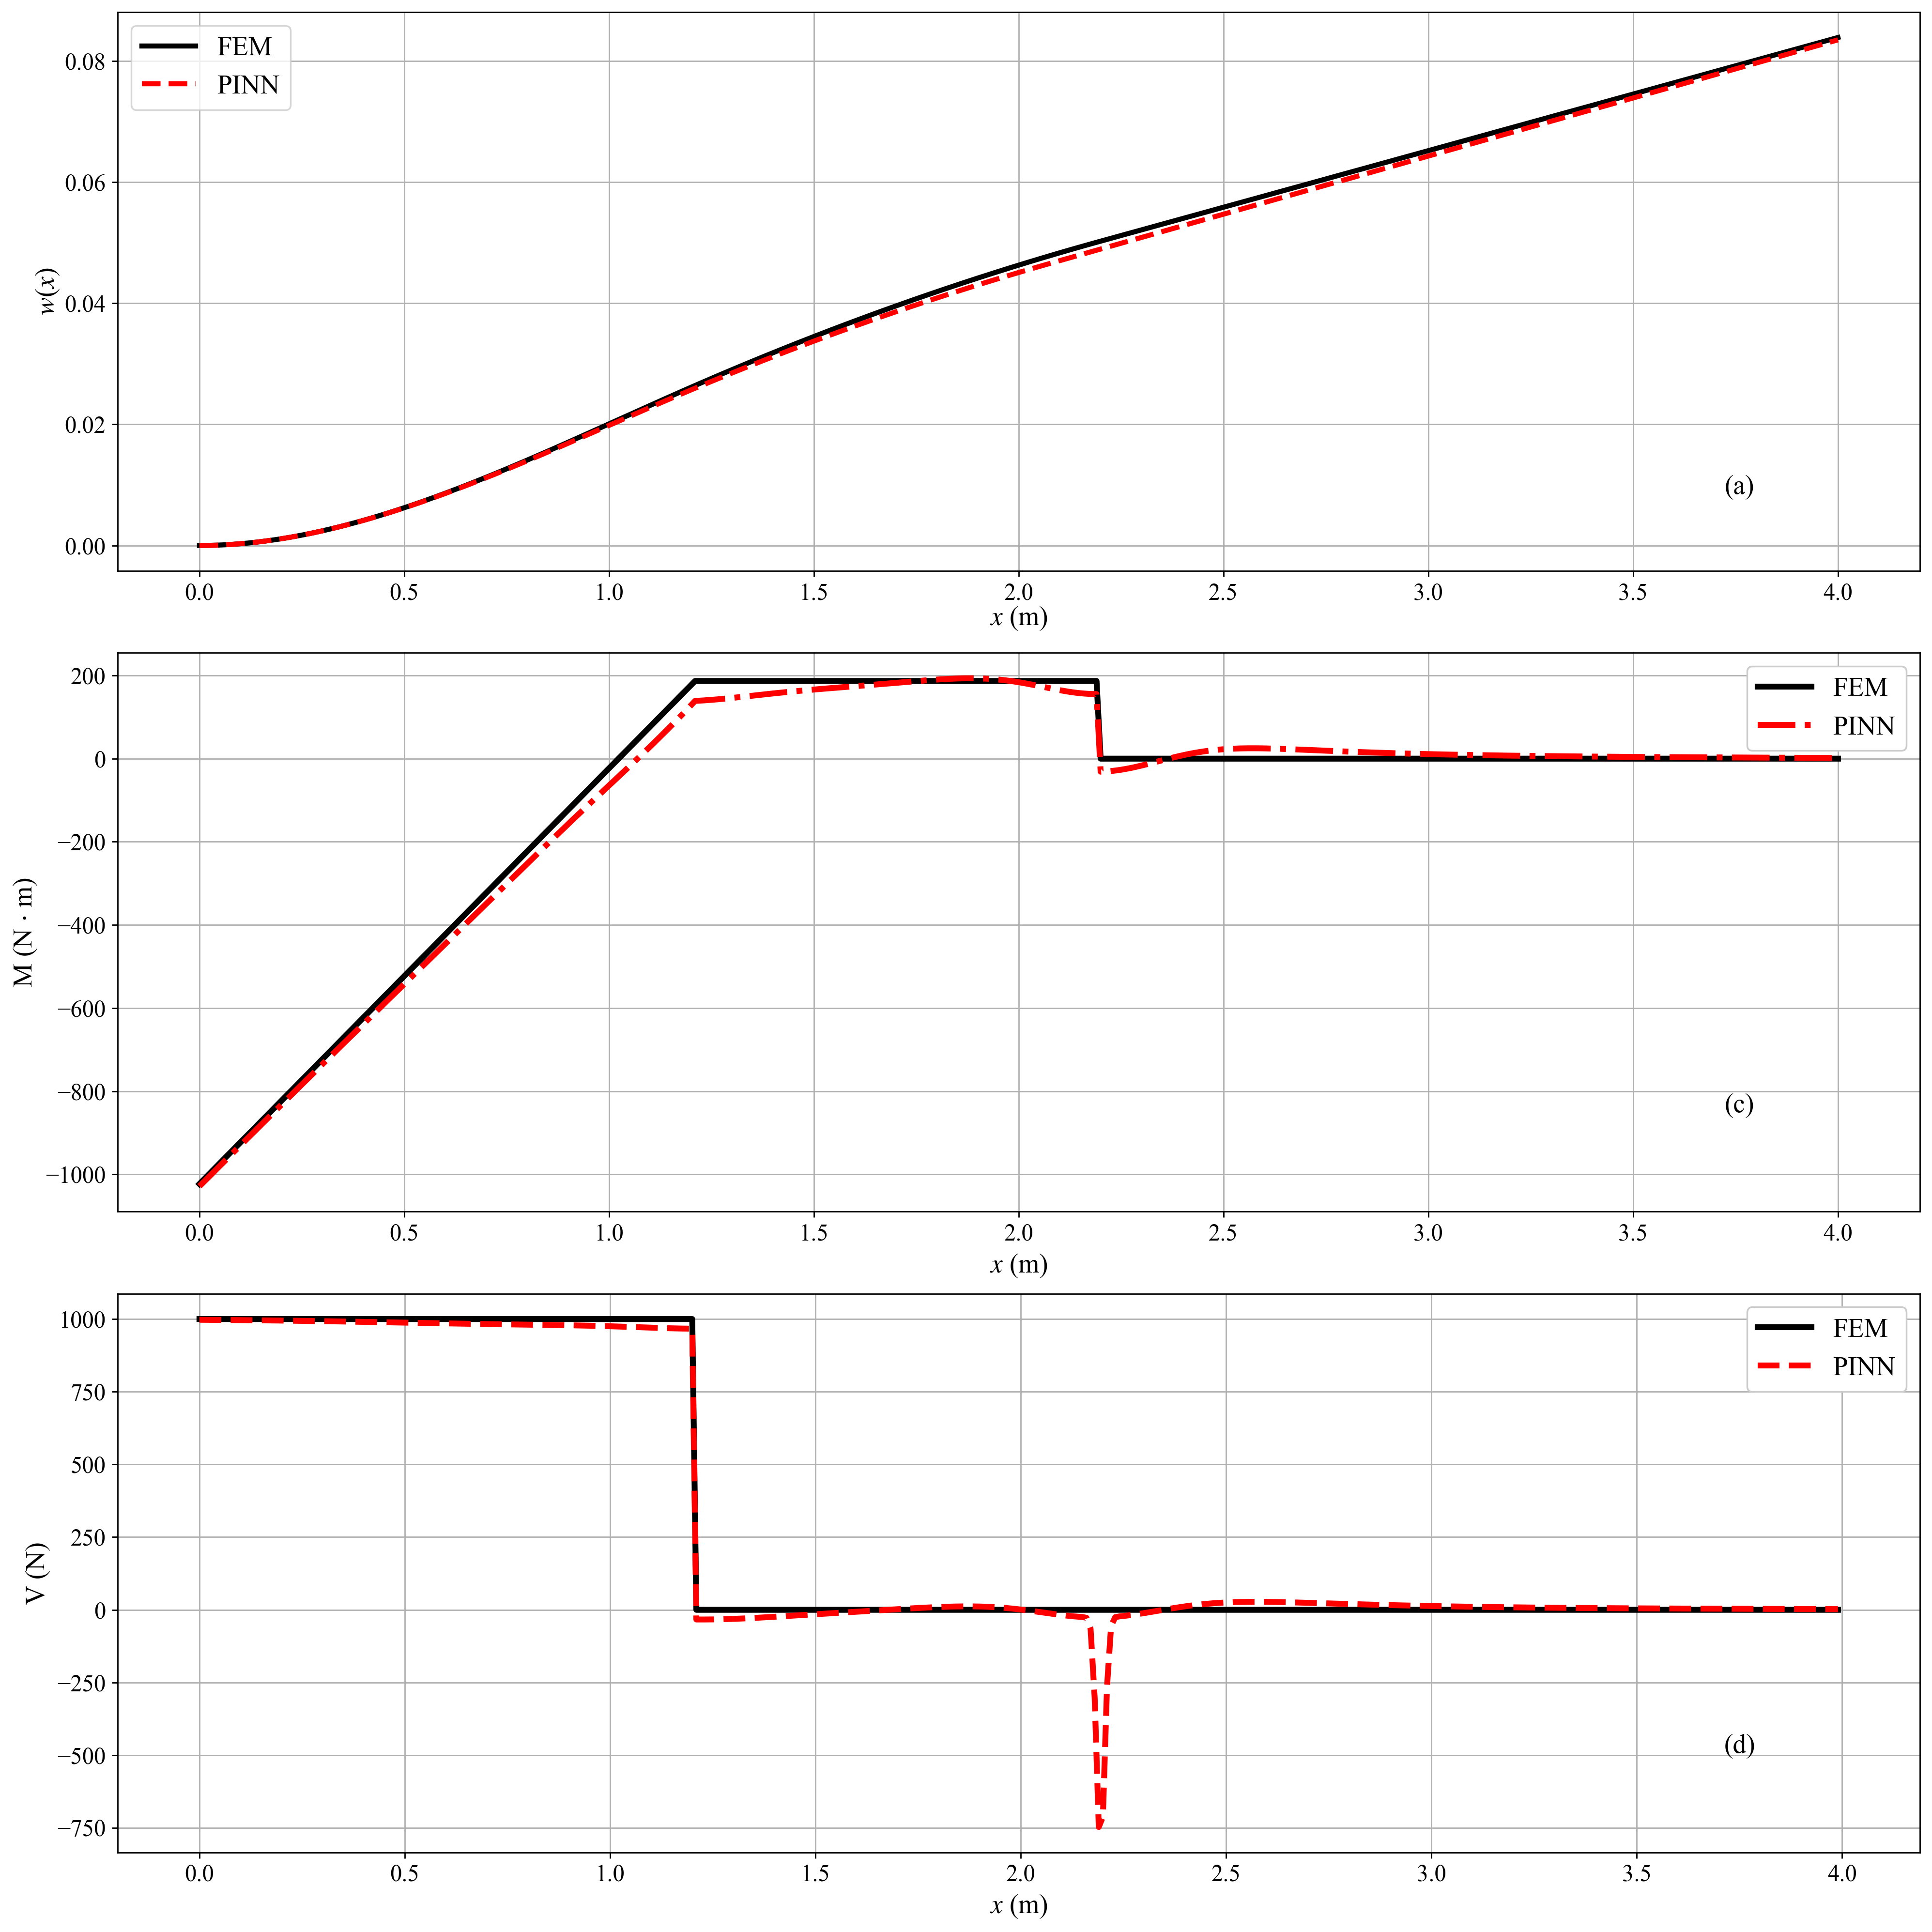

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

mpl.rcParams['figure.dpi'] = 250
axes = {'labelsize': 'large'}
font = {'family': 'serif',
        'weight': 'normal',
        'size': 5}
legend = {'fontsize': 'medium'}
lines = {'linewidth': 3,
         'markersize': 7}

mpl.rc('font', **font)
mpl.rc('axes', **axes)
mpl.rc('legend', **legend)
mpl.rc('lines', **lines)
#设置坐标轴字体
font1 = {'family':'Times New Roman','style':'normal','weight':'normal','size':9}  #italic是斜体
font2 = {'family':'Times New Roman','style':'normal','weight':'normal','size':14}
font3 = {'style':'normal','weight':'normal','size':16}

config = {

    "font.family": 'serif',

    "font.size": 8,

    "mathtext.fontset": 'stix',

    "font.serif": ['Times New Roman'],

}

plt.rcParams.update(config)  #很重要
# 创建图形对象和子图
# fig, axs = plt.subplots(2, 2,figsize=(12,8))
fig, axs = plt.subplots(3, 1,figsize=(16,16))
# fig.delaxes(axs[2][1])
# fig.delaxes(axs[1][1])

# 第一个子图：PINN挠度预测
file_path = 'C:/jiamin/dem-stastic-paper1/EulerBeam/disp_plot_constant_elasticsupport.txt'
data = np.loadtxt(file_path)
w_fem = np.array(data[:,1:2])
axs[0].plot(data[:,0:1], w_fem, label='FEM', lw=3, color='black')
axs[0].plot(x_predict, u_pred, label='PINN', lw=3, color='red',linestyle='dashed')
# ax1.yaxis.set_tick_params(labelsize=8,fontproperties = 'Times New Roman', size = 8)
# ax1.xaxis.set_tick_params(labelsize=8,fontproperties = 'Times New Roman', size = 8)
axs[0].tick_params(axis='both',which='major',labelsize=14)
labels = axs[0].get_xticklabels() + axs[0].get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]
axs[0].set_xlabel('$x$ (m)', labelpad=0.1, fontdict=font3)
axs[0].set_ylabel('$w$($x$)', labelpad=2, fontdict=font3, rotation=90)
axs[0].set_title('(a)', x=0.9, y=0.12, fontdict=font3)
axs[0].legend(prop=font3)
axs[0].grid(True)


#-----------------------------------------------------------------弯矩计算--------------------------------------------------------#

file_path = 'C:/jiamin/dem-stastic-paper1/EulerBeam/ElasticSupportBendingMoment.txt'
data = np.loadtxt(file_path)
Moment_fem = data[:,1:2]
axs[1].plot(data[:,0:1], Moment_fem, label='FEM',color='black', lw=3.5)
axs[1].plot(x_predict, Moment_pinn, label='PINN', color='red',linestyle='dashdot',lw=3.5)
axs[1].tick_params(axis='both',which='major',labelsize=14)
#axs[1, 0].set_yticks([10**i for i in range(0, 10, 3)]) 
labels = axs[1].get_xticklabels() + axs[1].get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels] 
axs[1].set_xlabel('$x$ (m)',fontdict=font3)
axs[1].set_ylabel(r'M (N $\cdot$ m)',fontdict=font3)
axs[1].set_title('(c)', x=0.9, y=0.16, fontdict=font3)
axs[1].legend(prop=font3,framealpha=1)
axs[1].grid(True)

file_path = 'C:/jiamin/dem-stastic-paper1/EulerBeam/ElasticSupportShearForce.txt'
data = np.loadtxt(file_path)
Shearforce_fem = data[:,1:2]
axs[2].plot(data[:,0:1], Shearforce_fem, label='FEM', color='black',lw=3.5)
axs[2].plot(x_predict, V_pinn, label='PINN', color='red',linestyle='dashed',lw=3.5)
axs[2].set_xlabel('$x$ (m)',fontdict=font3)
axs[2].set_ylabel('V (N)',fontdict=font3)
axs[2].tick_params(axis='both',which='major',labelsize=14)
#axs[1, 0].set_yticks([10**i for i in range(0, 10, 3)]) 
labels = axs[2].get_xticklabels() + axs[2].get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels] 
# axs[1].set_title('Shear Force Distribution')
axs[2].legend(prop=font3,framealpha=1)
axs[2].set_title('(d)', x=0.9, y=0.16, fontdict=font3)
axs[2].grid(True)

import os
folder_path = 'C:/jiamin\dem-stastic-paper1/EulerBeam/VPINN/code/Data'

data = {'x_vals': x_predict, 'w_vals': u_pred,'m_vals': Moment_pinn,'v_vals': V_pinn}
data_file_path = os.path.join(folder_path, 'F-EE-F-pinn_data.npy')
np.save(data_file_path, data)

error_L2_u = np.linalg.norm(w_fem - u_pred, 2) / np.linalg.norm(w_fem, 2)
error_L2_M = np.linalg.norm(Moment_fem - Moment_pinn, 2) / np.linalg.norm(Moment_fem, 2)
error_L2_V = np.linalg.norm(Shearforce_fem - V_pinn, 2) / np.linalg.norm(Shearforce_fem, 2)
#error_L2_psi = np.linalg.norm(exact_solution_psi - psi_pred, 2) / np.linalg.norm(exact_solution_psi, 2)
#error_L2_dudx = np.linalg.norm(exact_solution_dudx - dudx, 2) / np.linalg.norm(exact_solution_dudx, 2)

#     error_L2_u_relu = np.linalg.norm(exact_solution - u_pred, 2) / np.linalg.norm(exact_solution, 2)
#     error_L2_M_relu = np.linalg.norm(exactM - vpinn_M, 2) / np.linalg.norm(exactM, 2)
#     error_L2_V_relu = np.linalg.norm(exactV - vpinn_V, 2) / np.linalg.norm(exactV, 2)
#     error_L2_psi_relu = np.linalg.norm(exact_solution_psi - psi_pred, 2) / np.linalg.norm(exact_solution_psi, 2)
#     error_L2_dudx_relu = np.linalg.norm(exact_solution_dudx - dudx, 2) / np.linalg.norm(exact_solution_dudx, 2)
print("u ||e||L2 : %.2e" % error_L2_u)
print("M ||e||L2 : %.2e" % error_L2_M)
print("V ||e||L2 : %.2e" % error_L2_V)

# 调整子图间距
plt.tight_layout()
# path_save_pic = "C:/jiamin/dem-stastic-paper1/EulerBeam"
# plt.savefig(path_save_pic + "/comparisonElasticSupportEulerResponse.eps",format='eps', dpi=600)

# 显示图形
plt.show()


In [85]:
cor_L2_left = np.argmin(np.abs(x_pinn - L2+0.01))
cor_L2_right = np.argmin(np.abs(x_pinn - L2 - 0.01))
M_fem_left = Moment_fem[cor_L2_left]
M_pinn_left = Moment_pinn[cor_L2_left]
M_fem_right = Moment_fem[cor_L2_right]
M_pinn_right = Moment_pinn[cor_L2_right]
print(M_fem_left,M_pinn_left)
print(M_fem_right,M_pinn_right)

cor_L1_left = np.argmin(np.abs(x_pinn - L1+0.01))
cor_L1_right = np.argmin(np.abs(x_pinn - L1 - 0.01))
V_fem_left = Shearforce_fem[cor_L1_left]
V_pinn_left = V_pinn[cor_L1_left]
V_fem_right = Shearforce_fem[cor_L1_right]
V_pinn_right = V_pinn[cor_L1_right]
print(V_fem_left,V_pinn_left)
print(V_fem_right,V_pinn_right)

[186.90477] [155.42964277]
[5.9551421e-05] [-30.92028975]
[999.99999] [966.98657929]
[-1.399219e-05] [-33.25437836]
